In [1]:
import os
from pynq import Overlay
import xrfclk
import numpy as np
from pynq import Xlnk
from pynq import Overlay
import matplotlib.pyplot as plt
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
Npar = 1. # parallel paths multiplier
fs = 409.6 # MHz
print(xrfclk.get_freq_list())
xrfclk.set_all_ref_clks(fs)

dict_keys([102.4, 204.8, 409.6, 737])


In [3]:
firmware = Overlay('basicRFSoC4.bit')

In [4]:
cordic_ip = firmware.cordic2_0

In [5]:
cordic_ip.write(0x00,8)

In [6]:
def updatefreq(freq):
    cordic_ip.write(0x00,freq) #511 max

In [7]:
interact(updatefreq,freq=ipw.IntSlider(min=0,max=500,step=1,value=400));

interactive(children=(IntSlider(value=400, description='freq', max=500), Output()), _dom_classes=('widget-inte…

In [8]:
pulse_ip = firmware.tlast_gen_0
tlast_freq = 2**9
pulse_ip.write(0x00,tlast_freq)

In [9]:
dma = firmware.axi_dma_0

In [16]:
xlnk = Xlnk()
buffer_len = 1<<9 # largest buffer 9
buffer = xlnk.cma_array(shape=(buffer_len,), dtype=np.uint32)
dma.recvchannel.transfer(buffer)
dma.recvchannel.wait()

In [17]:
import time
time.sleep(10)
print("ZZZzzzzzz")

ZZZzzzzzz


In [22]:
dma.recvchannel.transfer(buffer)
dma.recvchannel.wait()
buffer

ContiguousArray([4214489791, 4198169801,   56492940,  118686386,
                 4216128433,  187564706, 4176282456,  203489722,
                 4141548200,  212992230, 4111008242,  215613485,
                 4089643323,  208535327, 4074373227,  192478791,
                 4067229598,  172555635, 4071161581,  143785260,
                 4083744258,  109706338, 4098817433,   70384655,
                 4128701635,   28113836, 4158651445, 4283759542,
                 4197579730, 4240112593, 4240178139, 4200791030,
                 4285463495, 4164811876,   33749986, 4133289181,
                   77790249, 4107206034,  116718778, 4091608625,
                  154926447, 4082827044,  182910432, 4079353851,
                  206503621, 4085711058,  219479951, 4101308846,
                  225443953, 4121756258,  223347003, 4154262265,
                  215417341, 4184540038,  196149894, 4223861751,
                  168493906, 4266263629,  135529399,   13698153,
                   927344

In [23]:
# read buffer uint32 values into signed int16
data_u32 = buffer

In [24]:
from struct import unpack

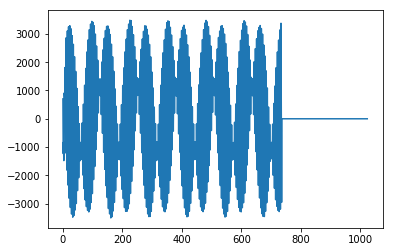

In [25]:
I0, I1 = np.zeros(len(buffer)), np.zeros(len(buffer))
for i in range(len(buffer)):
  I0[i],I1[i] = unpack("hh",data_u32[i])

# interweaving
I = np.zeros(len(I0)*2)
for ii in range(len(I0)):
    I[ii*2] = I0[ii]
    I[ii*2+1] = I1[ii]
plt.figure()
plt.plot(I)

In [ ]:
I = np.concatenate

In [ ]:
I = np.stack

In [ ]:
I = np.hstack

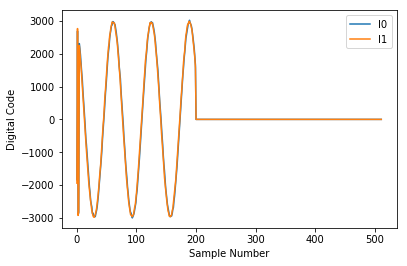

In [203]:
%matplotlib inline
plt.figure()
plt.plot(I0,label="I0")
plt.plot(I1,label="I1")
plt.ylabel("Digital Code")
plt.xlabel("Sample Number")
plt.legend()

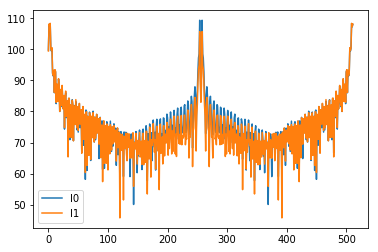

In [175]:
I0_spec = np.fft.fft(I0)
I1_spec = np.fft.fft(I1)
%matplotlib inline
plt.figure()
#plt.plot(abs(I0_spec),label="I0")
#plt.plot(abs(I1_spec),label="I1")
plt.plot(10.*np.log10(abs(I0_spec)**2),label="I0")
plt.plot(10.*np.log10(abs(I1_spec)**2),label="I1")
plt.legend()
plt.show()

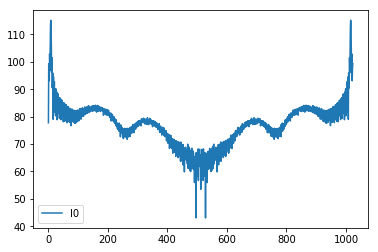

array([-1839., -1943.,  2691., ...,     0.,     0.,     0.])

In [205]:
I_spec = np.fft.fft(I)
%matplotlib inline
plt.figure()
#plt.plot(abs(I0_spec),label="I0")
#plt.plot(abs(I1_spec),label="I1")
plt.plot(10.*np.log10(abs(I_spec)**2),label="I0")
plt.legend()
plt.show()
I

In [16]:
# get timestream from DMA and plot
%matplotlib widget

def getTS():
  dma.recvchannel.transfer(buffer)
  dma.recvchannel.wait()
  I0, I1 = np.zeros(len(buffer)), np.zeros(len(buffer))
  for i in range(len(buffer)):
    I0[i],I1[i] = unpack("hh",buffer[i])
  return I0,I1

import time

def plotTS():
  count = 0
  fig = plt.figure()
  ax = fig.add_subplot(111)
  fig.show()
  fig.canvas.draw()
  while (count < 10):
    I0, I1 = getTS()
    ax.clear()
    ax.plot(I0)
    fig.canvas.draw()
    time.sleep(1)
    count += 1
  return

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

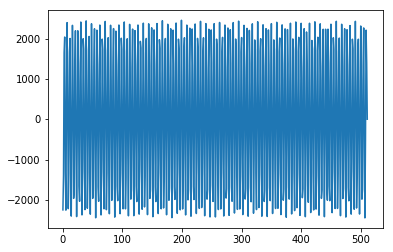

In [17]:
plotTS() 

In [18]:
import time
time.sleep(0.1)